# GEOG 6960 Causality in Geog. Studies 12

## Introduction

In this lab, we'll take a look at uplift modeling. This is an extension to causal machine learning that focuses on trying to better understand the variations in the treatment effect among individuals. One particular goal is to try and identify both the individuals who have the greatest effect and those who have the lowest. This information can then be used to better targer treatment in marketing, medicine, etc. There are several Python libraries that are designed to help with this, including **pylift**, **causalML** and **scikit-lift**. We'll use the last of these here in conjunction with the **EconML** library for modeling.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from econml.dml import LinearDML
from lightgbm import LGBMRegressor, LGBMClassifier


## Data

We'll use the data in the file *vocational.csv* for this lab. This is a synthetic dataset examining the effect of training (the `treatment`) on a student's success (the `outcome`), measured by whether or not they were able to obtain a job in the six months following the training. 

The goal is to first ensure that the training is useful generally. This can be measured by the average treatment effect (ATE). Second, as the training is expensive and resources are limited, we want to identify the students for whom the training is most effect so that we can prioritize these in the future. To assess this, an experiment was designed in which 15,000 students were randomly selected to receive the training, and a similar number as controls. 


The dataset contains the following fields. We assume that the other variables recorded can act as confounders in the model.

- `treatment`: if or not the student got treatment. It is assigned at random
- `age`: the age of the student training ranges from 18–22
- `score`: the score they obtain at school level examination (grade 10)
- `gender`: Male or Female
- `experience`: if they have previous experience or not
- `previous_exp`: how many months of previous experience
- `distance_majorcity`: how far they live from a major city
- `owns_motor`: if they have a motor vehicle
- `placement`: did they get the job after the end of their education

In [2]:
df = pd.read_csv("./data/vocational.csv")
df.columns

Index(['ind', 'treatment', 'age', 'score', 'gender', 'experience',
       'previous_exp', 'distance_majorcity', 'owns_motor', 'placement'],
      dtype='object')

Next, let's pre-process the data. We'll need to remove the ID field (`ind`) and one-hot encode the `gender` variable. 

In [3]:
dummies = pd.get_dummies(df['gender'], drop_first=True, dtype='int')
df = pd.concat([df, dummies], axis=1)
user_id = df['ind'] ## Store IDs for later use
df.drop(['ind','gender'], axis=1, inplace=True)

In [4]:
df.head()

,treatment,age,score,experience,previous_exp,distance_majorcity,owns_motor,placement,M
0,0,18,75,0,0,3.567556,1,0,0
1,1,19,73,0,0,5.726959,1,0,1
2,1,20,77,1,16,8.398042,0,1,1
3,0,20,71,0,0,4.364674,1,0,0
4,1,22,78,0,0,5.342594,1,0,0


In [5]:
print('Total number of samples: {}'.format(len(df)))

Total number of samples: 30000


The data are roughly equally split between control (`treatment = 0`) and treated (`treatment = 1`), so the data are roughly balanced. 

In [6]:
df['treatment'].value_counts(normalize = True)

treatment
0    0.501067
1    0.498933
Name: proportion, dtype: float64

For the outcome (`placement`), the data are unbalanced, with more 0's (students that did not get the job). In practice, it would be worth trying to balance this a little better for the modeling section (we won't do that here). 

In [7]:
df['placement'].value_counts(normalize = True)

placement
0    0.75
1    0.25
Name: proportion, dtype: float64

## Average treatment effect

Before we do anything else, let's get a naive estimate of the average treatment effect. We'll do this by simply comparing the conversion rate between the control and treatment group. The conversion rate is simply the number of successful placements divided by the total number of students in that group.

In [8]:
# Conversion and conversion rate by treatment group
treatment_group = df[df['treatment'] == 1]
control_group = df[df['treatment'] == 0]

# Number of users and conversion rate in treatment group
treatment_converted = treatment_group['placement'].sum()
treatment_total = len(treatment_group)
treatment_conversion_rate = treatment_converted / treatment_total

# Number of users and conversion rate in control group
control_converted = control_group['placement'].sum()
control_total = len(control_group)
control_conversion_rate = control_converted / control_total

# Create a summary table
summary_table = pd.DataFrame({
    '': ['Total Users', 'Converted Users', 'Conversion Rate (%)'],
    'Treatment Group': [treatment_total, treatment_converted, f"{treatment_conversion_rate * 100:.2f}%"],
    'Control Group': [control_total, control_converted, f"{control_conversion_rate * 100:.2f}%"]
})
display(summary_table)

# Difference in conversion rate
conversion_rate_difference = treatment_conversion_rate - control_conversion_rate
print(f"Difference in Conversion Rate between Treatment and Control Groups: {conversion_rate_difference * 100:.2f}% "
      f"(Treatment: {treatment_conversion_rate * 100:.2f}%, Control: {control_conversion_rate * 100:.2f}%)")

,,Treatment Group,Control Group
0,Total Users,14968,15032
1,Converted Users,4840,2660
2,Conversion Rate (%),32.34%,17.70%


Difference in Conversion Rate between Treatment and Control Groups: 14.64% (Treatment: 32.34%, Control: 17.70%)


From this we get:

- Treatment Group: 32.3% conversion rate (percentage of students who were trained and received a placement)
- Control Group: 17.7% conversion rate (percentage of tudents who were not trained and received a placement)
- A difference (ATE) of roughly 14.6%

This assumes that the treatment is assigned randomly - we'll next look at removing any bias in this and compare the results. 

Finally, we'll split up the data into the usually set of arrays:

- `X`: the features
- `y`: the outcome
- `T`: the treatment

Then we'll split into training and testing subsets. The training subset will be used for model fitting, and the testing set for model evaluation

In [9]:
features = ['age', 'score', 'experience', 'previous_exp',
       'distance_majorcity', 'owns_motor', 'M']
X = df[features]
y = df['placement']
T = df['treatment']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T, y, train_size=0.75)

## LinearDML

We'll use a double machine learning approach here. As a reminder: the argument `W` indicates that we want to use the features to debias the data (removing any confouding effect), and the argument `X` indicates that we want to use the features to estimate variations in the treatment effect by individual student. We'll start with the `linearDML` model, that estimates individual effects as a linear function of the features

In [11]:
np.random.seed(123)

dml = LinearDML(model_y='auto', 
                model_t='auto', 
                discrete_treatment=True)
dml.fit(y_train, T=T_train, X=X_train, W=X_train)

Once fit, we can extract the ATE from this model, as well as the set of individual effects with `effect`:

In [12]:
# Calculate average treatment effect
ate_dml = round(dml.ate(X=X_test), 2)
print(f"Estimated ATE: {ate_dml * 100:.2f}%")

# Get the individual treatment effect
treatment_effect = dml.effect(X=X_test.values)

Estimated ATE: 14.00%


Note here that the ATE is very slightly lower than in the naive estimate suggesting that there is some degree of non-randomness in the treatment assignments. The difference is pretty minimal here (due to the way that the data were produced). To illustrate this, we'll plot out the effects. For the control group, we simply need the control conversion rate (`control_conversion_rate`). For the treatment group, we'll decompose this into:

- The base conversion (i.e. the same as the control conversion)
- The treatment conversion (the true ATE)
- The selection bias as the total treatment effect minus the ATE + the base conversion

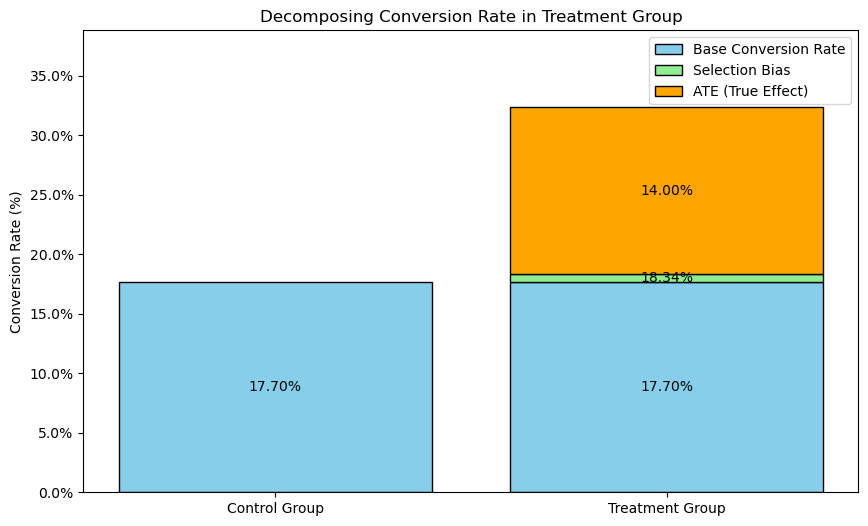

In [13]:
selection_bias = treatment_conversion_rate - ate_dml

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bars for Treatment Group
base_conversion = control_conversion_rate
selection_bias_height = selection_bias - control_conversion_rate
ate_height = ate_dml

# Create the bar plot
ax.bar('Control Group', control_conversion_rate, color='skyblue', edgecolor='black', label='Base Conversion Rate')
ax.bar('Treatment Group', base_conversion, color='skyblue', edgecolor='black')  # No label to avoid duplication
ax.bar('Treatment Group', selection_bias_height, bottom=base_conversion, color='lightgreen', edgecolor='black', label='Selection Bias')
ax.bar('Treatment Group', ate_height, bottom=base_conversion + selection_bias_height, color='orange', edgecolor='black', label='ATE (True Effect)')

# Adding text labels for each segment
ax.text(0, control_conversion_rate / 2, f'{control_conversion_rate * 100:.2f}%', ha='center', va='center', color='black', fontsize=10)
ax.text(1, base_conversion / 2, f'{base_conversion * 100:.2f}%', ha='center', va='center', color='black', fontsize=10)
ax.text(1, base_conversion + selection_bias_height / 2, f'{selection_bias * 100:.2f}%', ha='center', va='center', color='black', fontsize=10)
ax.text(1, base_conversion + selection_bias_height + ate_height / 2, f'{ate_dml * 100:.2f}%', ha='center', va='center', color='black', fontsize=10)

# Customizing plot
ax.set_ylim(0, treatment_conversion_rate * 1.2)
ax.set_ylabel('Conversion Rate (%)')
ax.set_title('Decomposing Conversion Rate in Treatment Group')

# Adding legend
ax.legend()

# Format y-axis to show percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1f}%'.format(y * 100)))

plt.show()

Now we'll examine the uplift from this model. The uplift is simply the individual treatment effect that we obtained earlier, but there are a couple of standard ways to visualize and examine this.

### Gain curve

The gain curve shows the cumulative effect of the treatment across the dataset. These values are created by first ordering the dataset from highest effect to lowest, then calculating the cumulative sum (this can also been done within percentile groups). If there is a large amount of variation in the effect size, this will form a curve that rises sharply, then flattens out. If there is no variation, this will simply form a flat line. The **causalml** package has a function (`plot_gain`) to do this. This requires a dataframe with 

- a column indicating whether or not an observation was treated
- the outcome
- the predicted effect

In [14]:
T_test

4542     0
11797    1
14397    0
16373    1
7174     0
        ..
18297    0
4772     0
3773     0
14381    0
17116    1
Name: treatment, Length: 7500, dtype: int64

In [15]:
uplift_results = pd.DataFrame({'DML': dml.effect(X_test)})
uplift_results = uplift_results.assign(is_treated=T_test.values, placement=y_test.values)

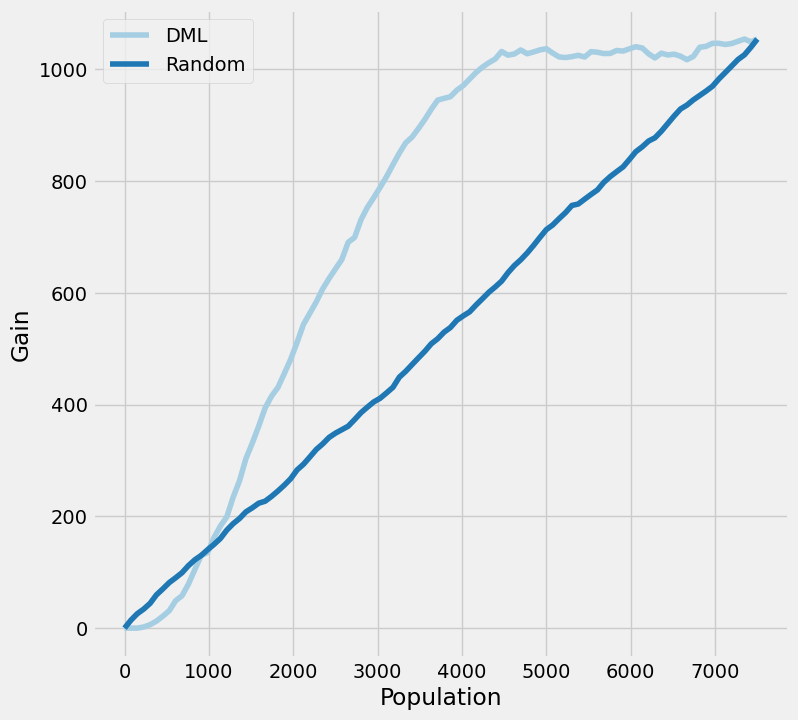

In [16]:
from causalml.metrics import plot_gain
plot_gain(uplift_results, outcome_col='placement', treatment_col='is_treated')

The graph shows the usual shape for a gain curve with a sharp rise in values that plateaus out at about 4000 individuals. This indicates that the majority of the uplift takes place in just over 50% of the population. For any selection purposes, this suggests that we should be able to identify a smaller set of individuals that could be focused on for the treatment, as the expected uplift would be positive. The remaining set have either a zero or negative uplift and can be safely ignored. Note that there is an odd effect at lower values - this is likely due to the choice of a linear model to estimate the effect. 

The area under the uplift curve (AUUC) can be used as a measure of how well the model captured variation in the treatment effect. The interpretation is similar to the AUROC metric that is widely used in ML. An AUUC of 0.5 indicates no variation, and AUUC's above about 0.8 are taken to have substantial variation. You can estimate this as follows. Here, We get a value of about 0.7.

In [17]:
from causalml.metrics import auuc_score
score = auuc_score(uplift_results, outcome_col='placement', treatment_col='is_treated')
print(score)

DML       0.695652
Random    0.498027
dtype: float64


The gain or uplift curve shows evidence of varied treatment effect among the students, but we don't currently have a way to identify who should be targeted. We can see this by building a CATE interpreter. This fits a simple decision tree to the predicted CATE values. The output gives the variable used to split the dataset into low and high treatment groups. We'll limit this here to a depth of 2 to help in interpretation

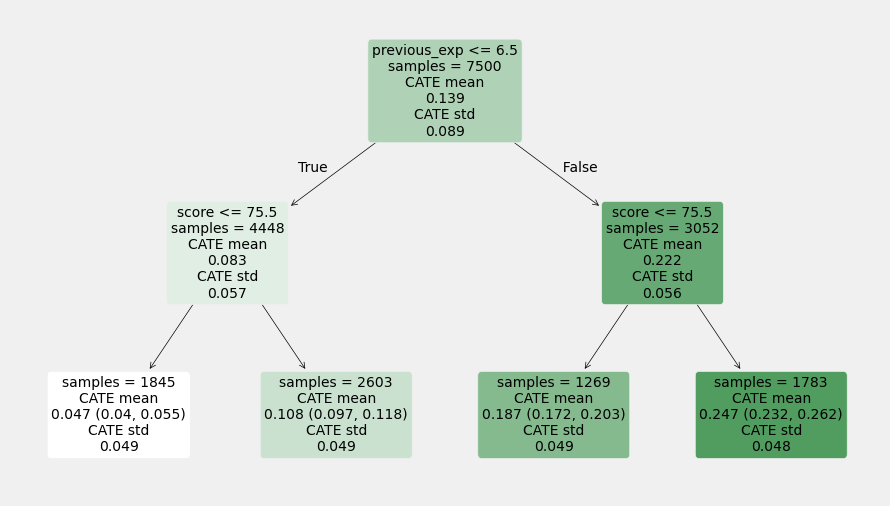

In [18]:
from econml.cate_interpreter import SingleTreeCateInterpreter
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp.interpret(dml, X_test)
# Plot the tree
fig, ax = plt.subplots(figsize=(10, 6))
intrp.plot(feature_names=features, fontsize=10)

The tree shows how the dataset is tree to maximize the difference between CATE values in the terminal nodes. In each node, you should see:

- The variable/value used to split the data
- The number of observations
- The CATE mean (the expected treatment effect)
- The CATE s.d.

In this case, we obtain four groups, ranging from low CATE ($\sim 0.055$) to high ($\sim 0.245$). This latter group represents students that have more experience (>=0.5) and score higher on tests (> 75.5), both of which could be used as factors to identify new students to train

## Causal Forest DML

We'll see if we can improve on these results by using a debiased causal forest (`CausalForestDML`). This replaces the linear model for treatment estimation from `LinearDML` with a causal forest. If the relationship between the features and the CATE is complex and non-linear, this should improve our results. 

In [19]:
np.random.seed(123)

from econml.dml import CausalForestDML

cfdml = CausalForestDML(model_t='auto',
                        model_y='auto',
                        discrete_treatment=True)


cfdml.fit(y_train, T_train, X=X_train, W=X_train)

Once again, we'll extract the ATE and individual treatment effects

In [20]:
# Calculate average treatment effect
ate_cfdml = round(cfdml.ate(X=X_test), 2)
print(f"Estimated ATE: {ate_cfdml * 100:.2f}%")

# Get the individual treatment effect
treatment_effect = cfdml.effect(X=X_test.values)

Estimated ATE: 14.00%


And we'll remake and plot the gain curve, now with the results of the causal forest

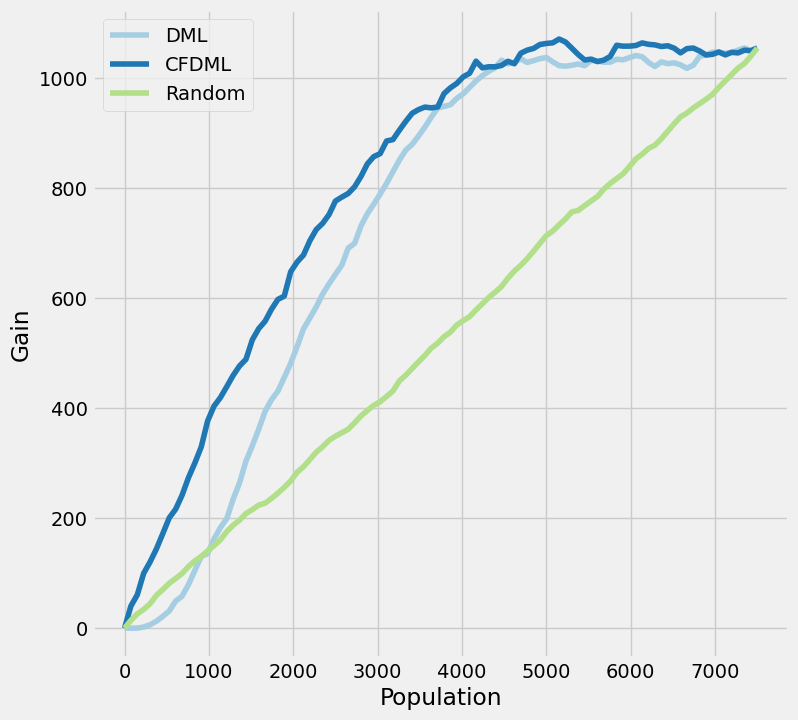

In [21]:
# uplift_results = pd.DataFrame({'effect': cfdml.effect(X)})
uplift_results = uplift_results.assign(CFDML=cfdml.effect(X_test))
plot_gain(uplift_results, outcome_col='placement', treatment_col='is_treated')

Hopefully you can see that the causal forest does a better job at differentiating between high and low effects. There is no longer the set of low values early on, and the curve rises faster, indicating that a higher proportion of the high effects are in the first groups. Normalizing the y-axis can also help (below). The plot shows the proportion of the total gain (or sum of individual effects) is explained as the population inccreases. With the causal forest, we get to over 80% of the total effect with less than 3,000 students or less than 50% of the population. Again, this indicates that it is possible to optimize the treatment or training to a smaller set of students who would benefit the most, reducing costs.

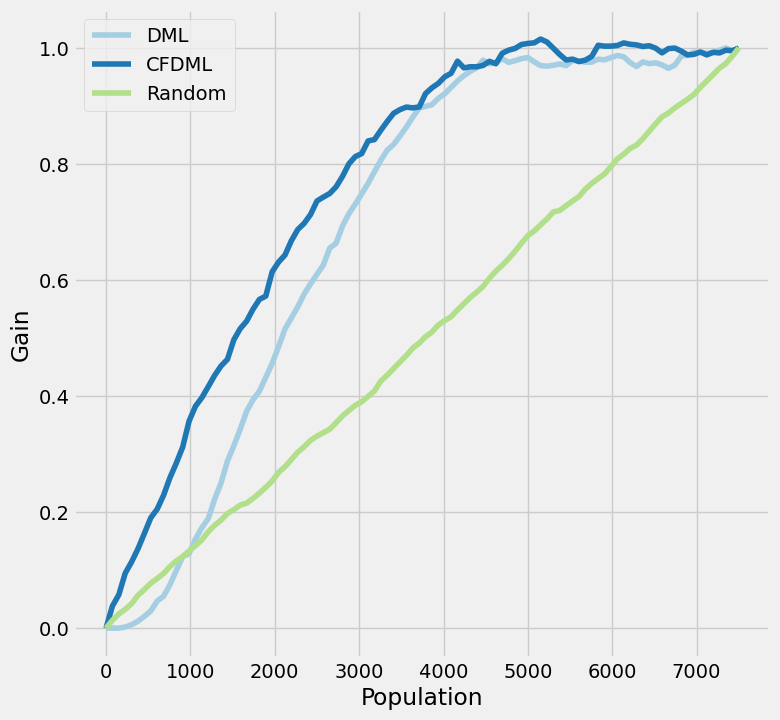

In [22]:
plot_gain(uplift_results, outcome_col='placement', treatment_col='is_treated', normalize=True)

Let's also check the AUUC:

In [23]:
score = auuc_score(uplift_results, outcome_col='placement', treatment_col='is_treated')
print(score)

DML       0.695652
CFDML     0.765986
Random    0.498027
dtype: float64


Finally, let's take a quick look at the CATE interpreter for this model. We'll increase the depth slightly to get more detail in the results. Note that the causal forest has used different variables to split the data (reflecting some of the non-linearities present).

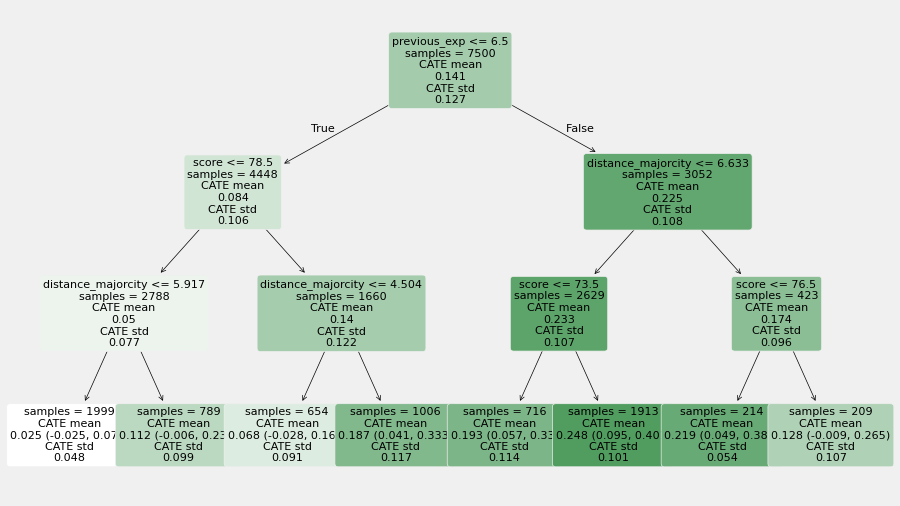

In [24]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=10)
intrp.interpret(cfdml, X_test)

# Plot the tree
fig, ax = plt.subplots(figsize=(10, 6))
intrp.plot(feature_names=features, fontsize=8)

## Interpretation

Finally, we can make some additional interpretations of the causal forest model. As this is based on a random forest, the model object includes the set of feature importances:

In [25]:
cfdml.feature_importances_

array([2.71203793e-02, 5.29954295e-02, 1.45476440e-01, 7.13823358e-01,
       5.55545106e-02, 4.69455841e-03, 3.35323856e-04])

<Axes: xlabel='importance', ylabel='feature'>

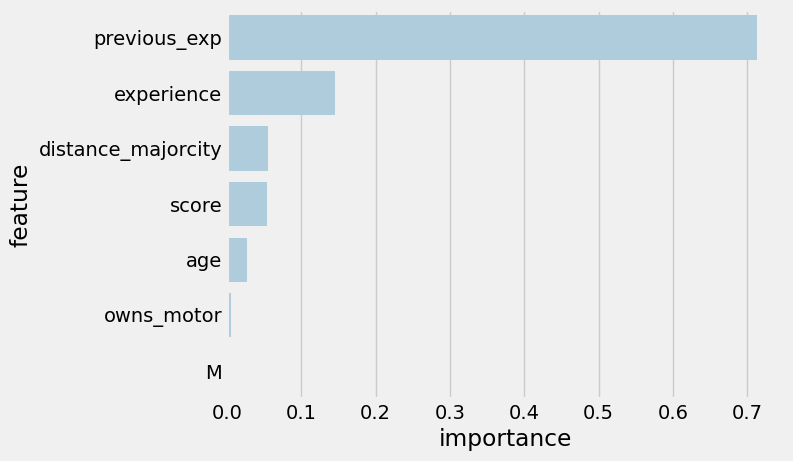

In [26]:
importances = cfdml.feature_importances_
indices = np.argsort(importances)[::-1]
df = pd.DataFrame({'feature': X.columns[indices],
                   'importance': importances[indices]})
#sns.set()
#sns.barplot(y = X.columns, x = importances)
sns.barplot(df, x = 'importance', y = 'feature')

We can also extract Shapley values. These are a frequently used method for interpretable machine learning, providing estimates of the contribution of each variable to an individuals predicted *effect*. As a rough explanation, the effect for an individual is predicted with the actual value of a variable (i.e. the true age) and then with the mean age of the population. If the difference between these is positive, this indicates that the individual value of that variable *increases* the outcome (in this case, the effect). If negative, then the the individual value *decreases* the outcome.

Models built with the **EconML** library usually contain Shapley values. Let's extract these and take a look

In [27]:
import shap
shap_values = cfdml.shap_values(X_test)

100%|===================| 7497/7500 [01:40<00:00]        

In [28]:
shap_values

{'placement': {'treatment_1': .values =
  array([[ 0.01711153,  0.03385255, -0.01421836, ..., -0.05655415,
           0.01428511,  0.0011182 ],
         [ 0.00536124,  0.03567439,  0.020387  , ...,  0.00397324,
           0.02378024, -0.0042792 ],
         [-0.00715245, -0.00940297,  0.01899314, ...,  0.02570429,
          -0.01676651, -0.0075876 ],
         ...,
         [ 0.0137987 ,  0.01845338, -0.01398887, ..., -0.03837413,
           0.00955633, -0.00064845],
         [ 0.04911982,  0.06039281, -0.01155129, ..., -0.01179057,
           0.02507836,  0.00243361],
         [ 0.05094873, -0.00826387, -0.00715338, ...,  0.04447035,
           0.02462158,  0.00872637]])
  
  .base_values =
  array([0.13984821, 0.13984821, 0.13984821, ..., 0.13984821, 0.13984821,
         0.13984821])
  
  .data =
  array([[19.        , 81.        ,  0.        , ...,  4.30414044,
           1.        ,  1.        ],
         [21.        , 77.        ,  1.        , ...,  3.8994963 ,
           1.        

The actual Shapley values are held in the first list (`placement`). This contains a list for each treatment level. Here, we only have one - but these can be used with multi-treatment datasets. We'll start with the global view. This plots all the values for each variable. The position on the x-axis indicates the impact: positive increases the outcome, negative decreases it. The colors represent the value of the variable from high to low. 

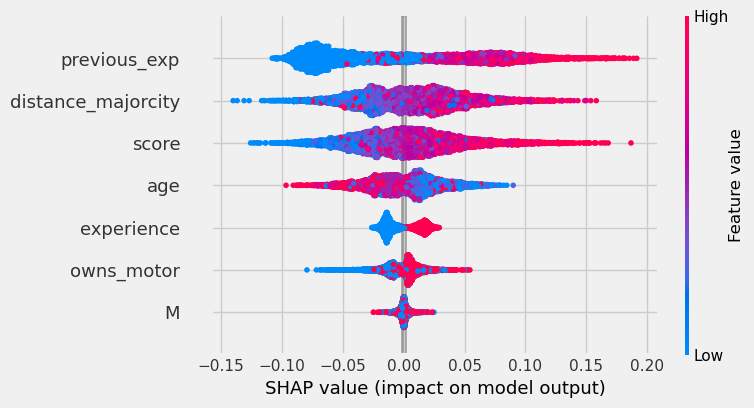

In [29]:
# global view: explain heterogeneity for a sample of dataset
shap.summary_plot(shap_values['placement']['treatment_1'])

We can also plot the Shapley values for an individual. Here's the plot for the third individual in the test set, who has an overall increase in effect ($\sim 0.19$). Red represents a positive impact, blue a negative impact (the overall Shapley predicted value is given in black at the top `f(x)`)

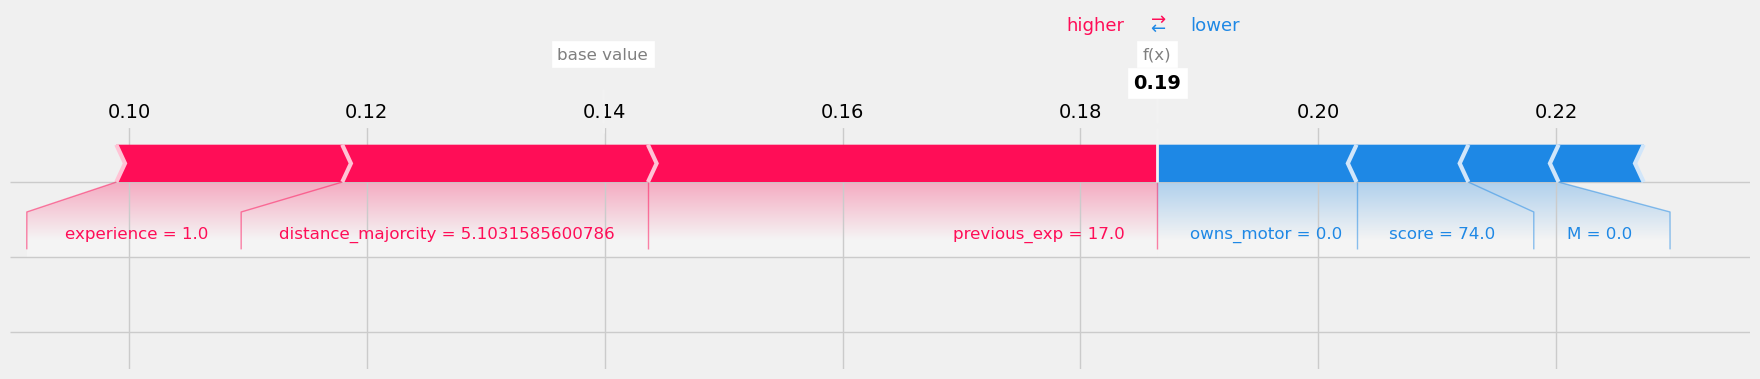

In [30]:
ind=2
shap.plots.force(shap_values['placement']['treatment_1'][ind], matplotlib=True)

This can also be plotted as a waterfall figure, which makes it a little easier to see some of the minor contributions

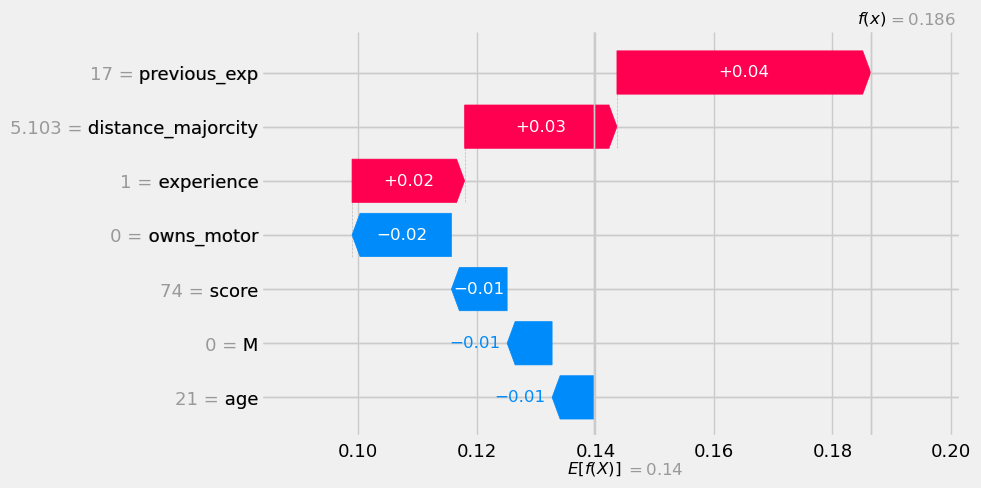

In [31]:
shap.plots.waterfall(shap_values['placement']['treatment_1'][ind])

And here's a second individual who has an overall decrease:

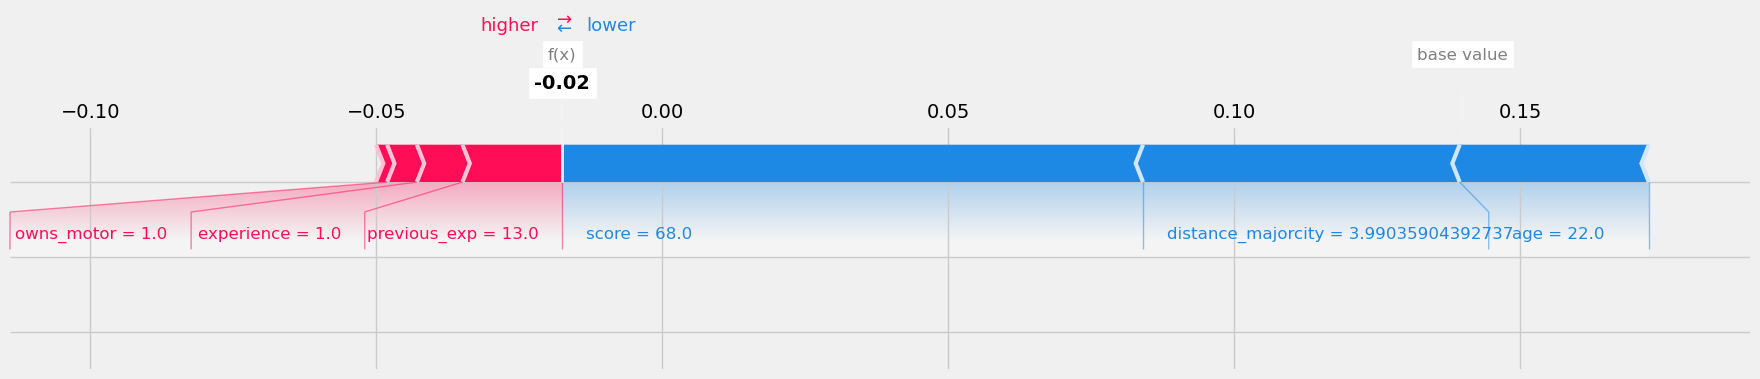

In [38]:
ind=200
shap.plots.force(shap_values['placement']['treatment_1'][ind], matplotlib=True)

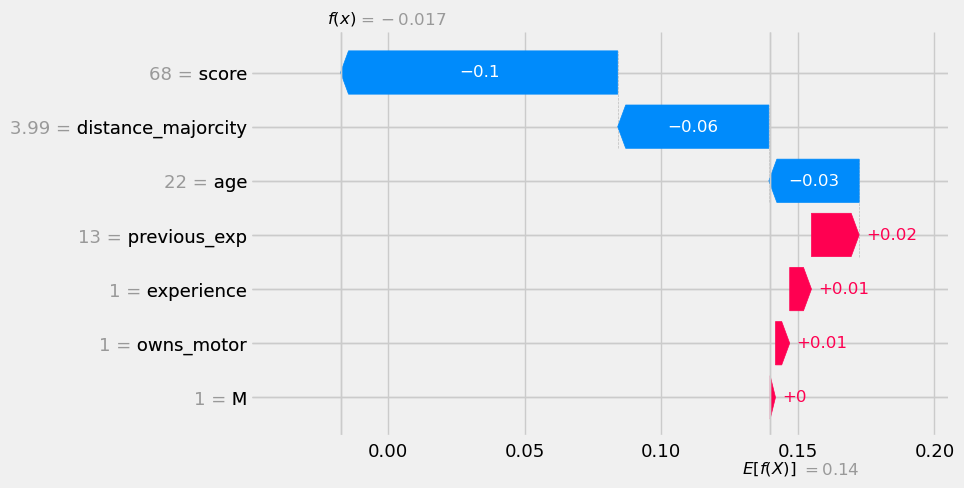

In [37]:
shap.plots.waterfall(shap_values['placement']['treatment_1'][ind])

## Grouping users

As a last step, we'll go through and label all of the students according to their effect score into decile groups. This could then be used for deciding the next training round. 

In [32]:
# Sort the uplift_results DataFrame by 'uplift' in descending order
uplift_results['user_id'] = X_test.index.values
uplift_results_sorted = uplift_results.sort_values(by='CFDML', ascending=False).reset_index(drop=True)

# Print the customer list
print("Customer List Sorted by Uplift:")
display(uplift_results_sorted[['user_id', 'CFDML']].head(10))


Customer List Sorted by Uplift:


,user_id,CFDML
0,26680,0.530354
1,29708,0.523566
2,9922,0.515550
3,7093,0.501515
4,5699,0.493038
5,13594,0.491895
6,5779,0.488829
7,18101,0.488418
8,7915,0.485493
9,4588,0.483628


In [33]:
# Calculate Rank and Decile Label
uplift_results_sorted['rank'] = uplift_results_sorted['CFDML'].rank(method='first', ascending=False)
uplift_results_sorted['decile'] = pd.qcut(uplift_results_sorted['rank'], 10, labels=False)

decile_labels = [
    "top 10%", "top 10%-20%", "top 20%-30%", "top 30%-40%", "top 40%-50%", 
    "top 50%-60%", "top 60%-70%", "top 70%-80%", "top 80%-90%", "bottom 10%"
]

column_order = ['user_id', 'CFDML', 'rank', 'decile', 'decile_label']
uplift_results_sorted['decile_label'] = uplift_results_sorted['decile'].map(lambda x: decile_labels[x])
display(uplift_results_sorted[column_order].head(10))

,user_id,CFDML,rank,decile,decile_label
0,26680,0.530354,1.0,0,top 10%
1,29708,0.523566,2.0,0,top 10%
2,9922,0.515550,3.0,0,top 10%
3,7093,0.501515,4.0,0,top 10%
4,5699,0.493038,5.0,0,top 10%
5,13594,0.491895,6.0,0,top 10%
6,5779,0.488829,7.0,0,top 10%
7,18101,0.488418,8.0,0,top 10%
8,7915,0.485493,9.0,0,top 10%
9,4588,0.483628,10.0,0,top 10%
